# Next Stories - not covered

<div>
   <img src="https://github.com/thomasmanke/ABS/raw/main/figures/Oyens1879_DeStamtafel.jpg",  width="500">
</div>

- Speed-up learning: 
  - gradient improvements (use "Adam" for now)
  - early stopping: monitor validation loss / accuracy
- Dealing with limited data
  - transfer learning: use other peoples network and learn only last layers (with less data)
  - Data Augmentation: rotate, crop, mirror, recolor, ...
- Avoid overfitting
  - dropout: remove random nodes during the learning process
  - add regularizers

# Klausur - Expectations

- Load Code: know which packages you'll need (pip install if necessary)

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
print('tf-version: ', tf.__version__)

# my plot function for confusion matrix
def plot_cm(mat):
  classes = np.arange(cm.shape[0])
  plt.imshow(mat, cmap=plt.cm.Blues)
  for (j,i),label in np.ndenumerate(mat):
    plt.text(i,j,np.round(label,2),ha='center',va='center')

  plt.colorbar()
  plt.title('Confusion Matrix')
  plt.xlabel('True label')
  plt.ylabel('Pred label')
  plt.xticks(classes)
  plt.yticks(classes)
  plt.show()



tf-version:  2.4.1


- Load Data: Code will be given, but downsampling may be required


In [10]:
cifar100 = tf.keras.datasets.cifar100
(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')
X_train.shape

n_down = 10000
n_down_test = int(n_down/5)

if (n_down>0):
  np.random.seed(42)
  print('train-before:', X_train.shape, y_train.shape)
  print('test-before: ', X_test.shape, y_test.shape)
  id_train = np.random.choice(X_train.shape[0],n_down)
  id_test  = np.random.choice(X_test.shape[0],n_down_test)
  X_train, y_train = X_train[id_train, ...], y_train[id_train, ...]
  X_test, y_test = X_test[id_test, ...], y_test[id_test, ...]
  print('train-after:', X_train.shape, y_train.shape)
  print('test-after: ', X_test.shape, y_test.shape)

# normalization
X_train, X_test = X_train / 255.0, X_test / 255.0


train-before: (50000, 32, 32, 3) (50000, 1)
test-before:  (10000, 32, 32, 3) (10000, 1)
train-before: (10000, 32, 32, 3) (10000, 1)
test-before:  (2000, 32, 32, 3) (2000, 1)


- Explore Data: know the shapes, number of samples, number of unique labels (classes)

In [15]:
print(X_train.shape)
print(X_test.shape)
print(min(y_train), max(y_train))




(10000, 32, 32, 3)
(2000, 32, 32, 3)
[0] [99]



- Define Model
  - define proper input shape
  - define layers (with activation functions) given a verbal prescription
  - define optimizer & metrics
  - summarize: how many parameters does the model have


In [24]:
#define proper input shape
input_shape = X_train.shape[1:]
print(input_shape)

(32, 32, 3)


In [25]:
nc = np.unique(y_train).size  # number of classes / labels in training set
model = tf.keras.models.Sequential(name='cifar_100')

# define layers
model.add(tf.keras.layers.InputLayer(input_shape))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', name='1st_conv'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# an additional layer
#model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='2nd_conv'))
#model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# as before
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu', name='last'))
model.add(tf.keras.layers.Dense(nc, activation='softmax', name='output'))

#define optimizers and metrics
l_name = 'sparse_categorical_crossentropy'
a_name = 'sparse_categorical_accuracy'
model.compile(optimizer='adam', loss=l_name, metrics=a_name)

#summarize
model.summary()

Model: "cifar_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1st_conv (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14400)             0         
_________________________________________________________________
last (Dense)                 (None, 128)               1843328   
_________________________________________________________________
output (Dense)               (None, 100)               12900     
Total params: 1,858,020
Trainable params: 1,858,020
Non-trainable params: 0
_________________________________________________________________


- Fit model:
  - epochs, validation_split
  - save model


In [26]:
fh = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=0)

model_fn   = model.name + '.h5'  
history_fn = model.name + '_history.npy'

2022-06-20 20:07:46.782779: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-20 20:07:46.797626: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2711995000 Hz


- Evaluate Model:
  - plot metrics, understand difference in accuracy  for train, validation and tets


63/63 [==============================] - 2s 32ms/step - loss: 3.8581 - sparse_categorical_accuracy: 0.2075


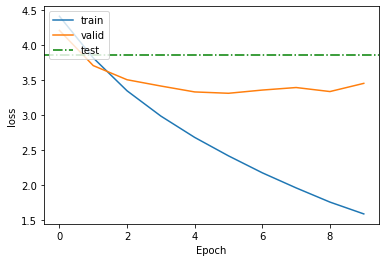

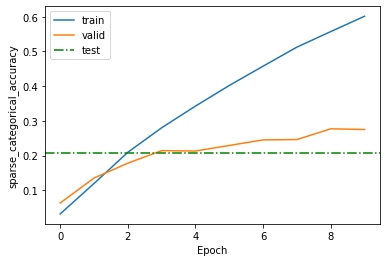

In [35]:
## Plotting history and test accuracy
def plot_fit_history(fh, name='loss', test_score=0):
  """Plots history of metrics 'name'
  The validation metrics will also be plotted if available as 'val_name' (Keras convention)
  A test_score can be added to compare the evolution"""

  if name not in fh.history:
      print('plot_fit_history: {} is not a key in history !'.format(name))
      return
  val_name = 'val_' + name
  plt.plot(fh.history[name],     label='train')

  if val_name in fh.history:
    # add validation if in data
    plt.plot(fh.history[val_name], label='valid')
  
  plt.axhline(y=test_score, color='green', linestyle='-.',label = 'test')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  plt.legend(loc='upper left')
  plt.show()

    
    
    
test_loss, test_acc = model.evaluate(X_test, y_test)

a_name='sparse_categorical_accuracy'
plot_fit_history(fh, 'loss', test_loss)
plot_fit_history(fh, a_name, test_acc)

- Run Predicitions:
  - for individual data set: what's the true and predicted label
  - (same for all test data: confusion matrix)

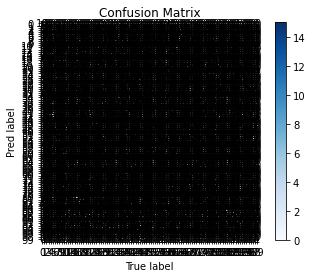

In [36]:
model_pred = model.predict(X_test)          # probabilities    
y_pred    = np.argmax(model_pred, axis=1)   # classes with max prob (= labels)
cm=confusion_matrix(y_pred, y_test)
plot_cm(cm)

(32, 32, 3)


/home/cq/miniconda3/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


ValueError: shape mismatch: objects cannot be broadcast to a single shape

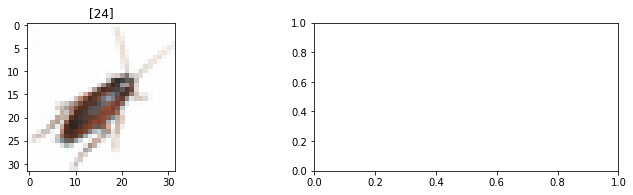

In [41]:
idx=7
X = X_test[idx]
print(X.shape)
X = np.expand_dims(X, axis=0)  #this all is synonymous to X_test[idx:idx+1,:,:,:]

pred = model.predict(X)
i_max=np.argmax(pred)
true_lab=y_test[idx]
pred_lab=[i_max]

plt.figure(figsize=(12,6))
ax = plt.subplot(2,2,1)
plt.imshow(X_test[idx]) 
plt.title(true_lab)

ax = plt.subplot(2,2,2)
plt.bar(range(10), pred[0])
plt.title(pred_lab)
plt.show()